<a href="https://colab.research.google.com/github/Auvarmf/Riset-MBKM-CNN2023/blob/main/Modelv1_Inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Input, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate
from keras.utils import plot_model, to_categorical
from keras.datasets import cifar10
from google.colab import drive

In [2]:
# Mount Google Drive to access files and folders
drive.mount('/content/MBKMCNN')

Mounted at /content/MBKMCNN


In [3]:
# Define the base directory where all images are stored
BASE_DIR = '/content/MBKMCNN/MyDrive/MBKMCNN/datasetv2_inception'
train_dir = '/content/MBKMCNN/MyDrive/MBKMCNN/datasetv2_inception/train'
val_dir = '/content/MBKMCNN/MyDrive/MBKMCNN/datasetv2_inception/validation'

class_names = []
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    if os.path.isdir(folder_path):
        class_names.append(folder)

# print(class_names)

class_names_label = {class_name: i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)

print(class_names_label)

IMG_SIZE = (32,32)


{'1917051029': 0, '1917051033': 1, '2017051044': 2, '2017051016': 3, '2017051033': 4, '2017051013': 5, '2017051031': 6, '2017051020': 7, '1917051047': 8, '2057051016': 9, '2017051081': 10, '2017051004': 11, '2017051079': 12, '1917051041': 13, '2017051017': 14, '2017051001': 15, '2157051006': 16, '2157051001': 17, '2117051095': 18, '2117051050': 19, '2117051048': 20, '2117051043': 21, '2117051027': 22, '2117051019': 23, '2117051009': 24}


In [4]:
def load_data():
    DIRECTORY = BASE_DIR
    CATEGORY = ["train", "validation"]

    output = []

    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []

        for folder in os.listdir(path):
            if folder in class_names:
                label = class_names.index(folder)

                for file in os.listdir(os.path.join(path, folder)):
                    img_path = os.path.join(os.path.join(path, folder), file)

                    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        image = cv2.imread(img_path)

                        if image is not None:
                            image = cv2.resize(image, IMG_SIZE)
                            images.append(image)
                            labels.append(label)

        images = np.array(images, dtype="float32")
        labels = np.array(labels, dtype="int32")

        output.append((images, labels))

    return output

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [6]:
train_images, train_labels = shuffle(train_images, train_labels, random_state = 25)

In [7]:
def display_examples(class_names, images, labels):
  figsize = (20,20)
  fig = plt.figure(figsize=figsize)
  fig.suptitle("Contoh Sampel Dataset", fontsize=16)
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # image = cv2.resize(images[i], figsize)
    plt.imshow(images[i].astype(np.uint8))
    plt.xlabel(class_names[labels[i]])
  plt.show()

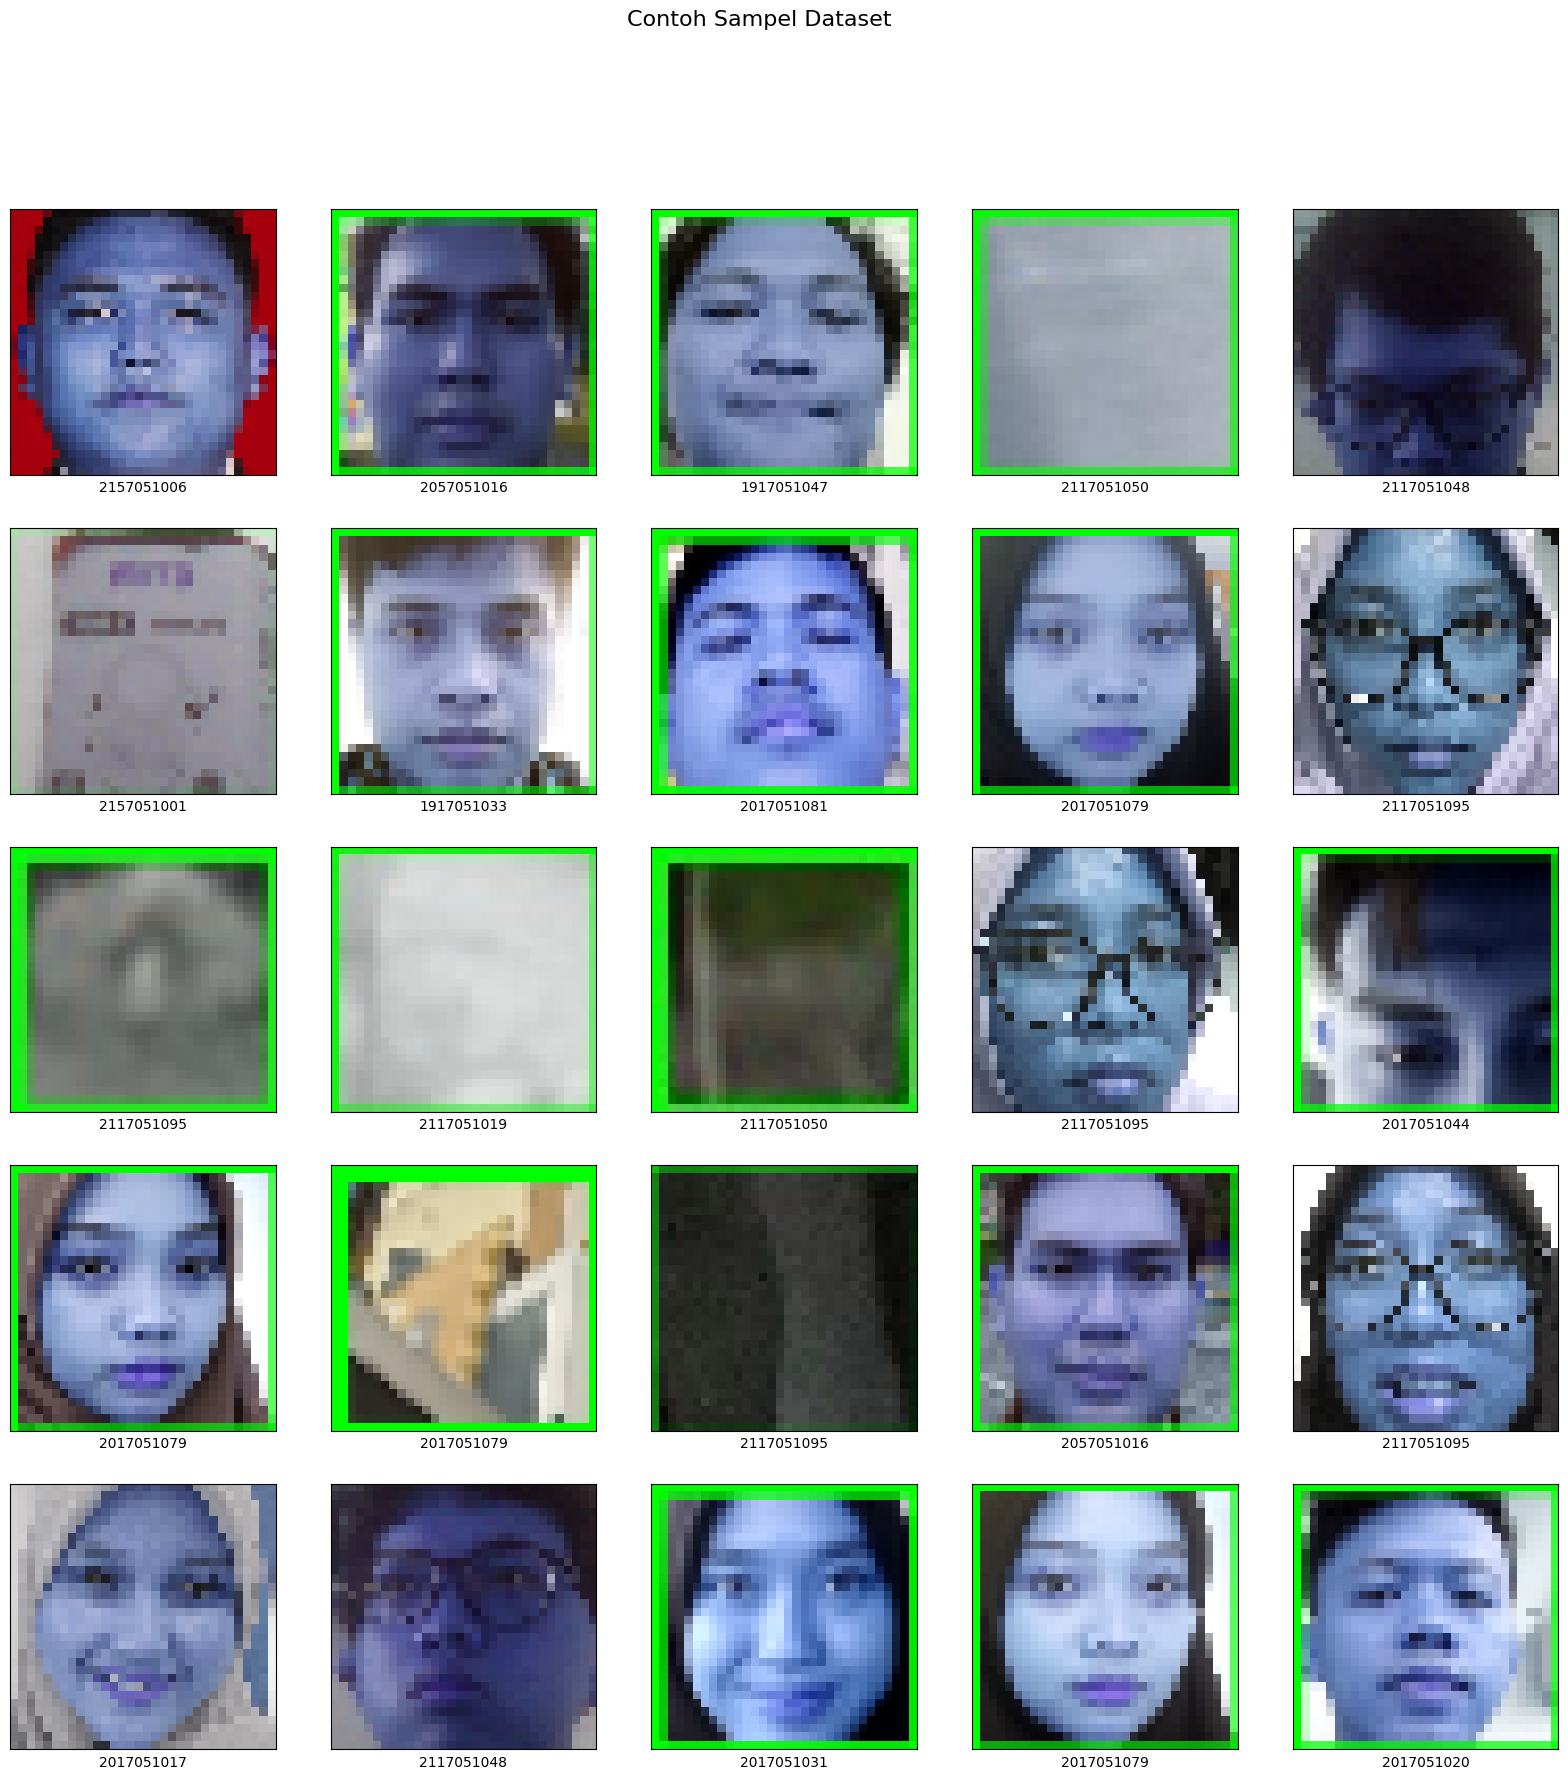

In [8]:
display_examples(class_names, train_images, train_labels)

In [9]:
train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)

In [10]:
train_dataset = train_data.flow_from_directory(train_dir,
                                               target_size=(32, 32),
                                               batch_size=32,
                                               class_mode='sparse')

validation_dataset = validation_data.flow_from_directory(val_dir,
                                                         target_size=(32, 32),
                                                         batch_size=32,
                                                         class_mode='sparse')

Found 497 images belonging to 25 classes.
Found 497 images belonging to 25 classes.


In [12]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 96)           384       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 32, 32, 16)           64        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 D)                                                                                           

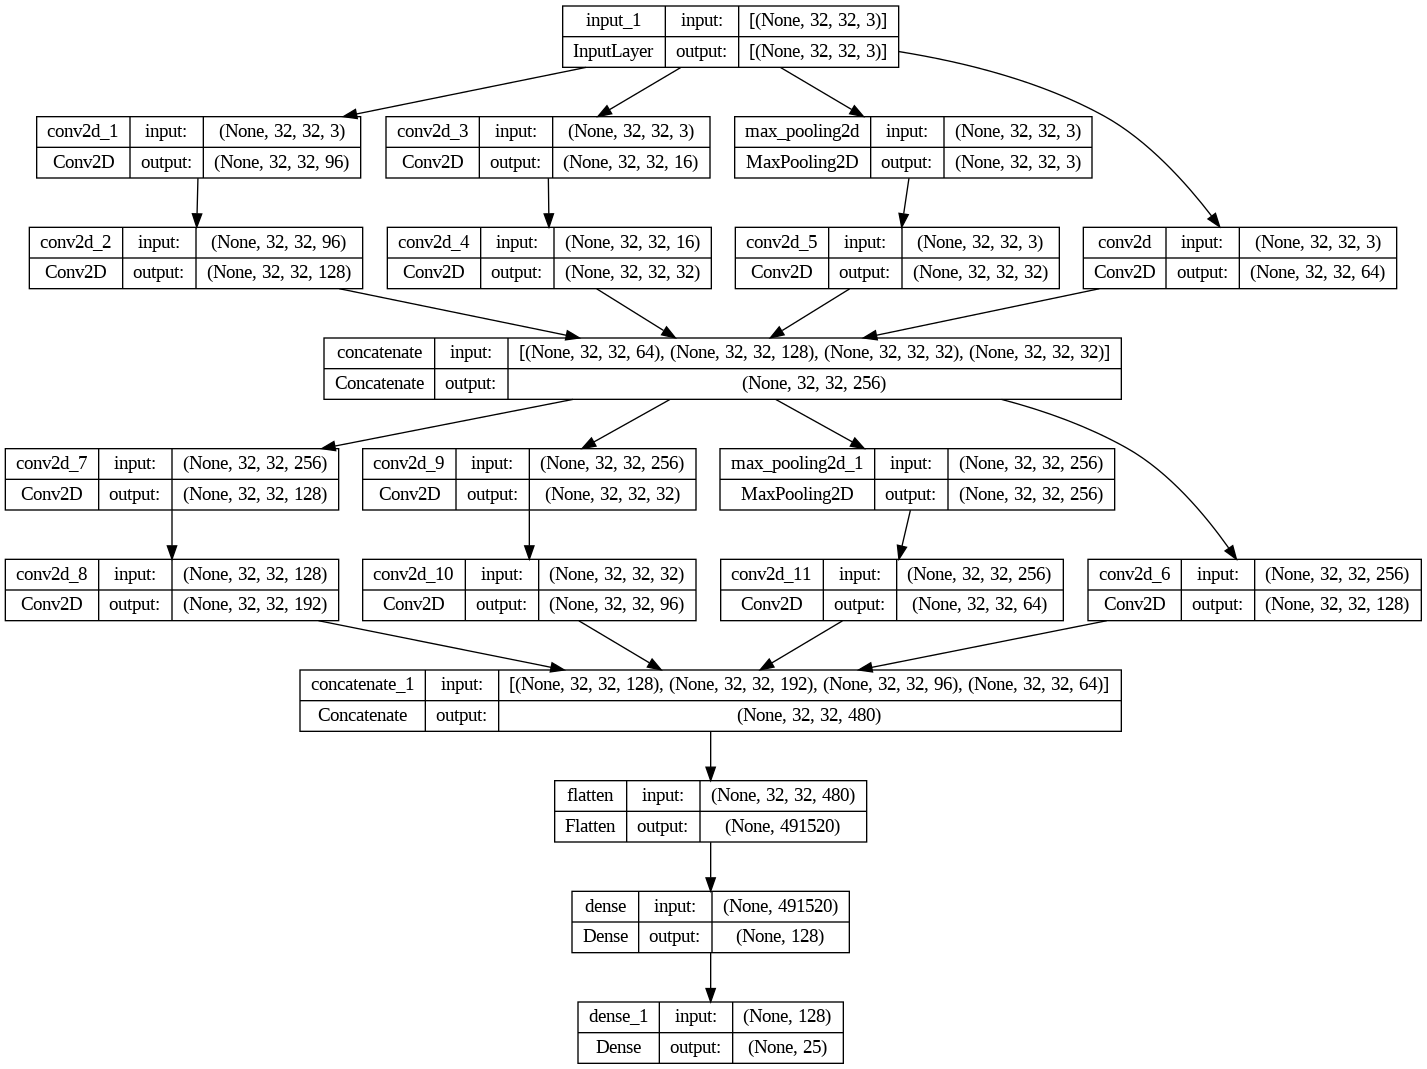

In [18]:
# define model input
visible = Input(shape=(32, 32, 3))
# add inception block 1
layer = inception_module(visible, 64, 96, 128, 16, 32, 32)
# add inception block 2
layer = inception_module(layer, 128, 128, 192, 32, 96, 64)

# Add Flatten layer to convert the spatial tensor to a vector
layer = Flatten()(layer)

# Add Dense layers for classification
layer = Dense(128, activation='relu')(layer)  # You can change the number of units as needed
output = Dense(train_dataset.num_classes, activation='softmax')(layer)  # nb_classes is the number of classes

# create model
model = Model(inputs=visible, outputs=output)

# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
4/4 [==============================] - 50s 11s/step - loss: 4965.6318 - accuracy: 0.0378 - val_loss: 3133.4912 - val_accuracy: 0.0700
Epoch 2/10
4/4 [==============================] - 46s 11s/step - loss: 2159.3806 - accuracy: 0.0302 - val_loss: 874.8175 - val_accuracy: 0.0400
Epoch 3/10
4/4 [==============================] - 49s 11s/step - loss: 574.3832 - accuracy: 0.0353 - val_loss: 97.5749 - val_accuracy: 0.1900
Epoch 4/10
4/4 [==============================] - 45s 11s/step - loss: 88.4553 - accuracy: 0.1335 - val_loss: 30.3033 - val_accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 45s 11s/step - loss: 23.4296 - accuracy: 0.0781 - val_loss: 8.6584 - val_accuracy: 0.1000
Epoch 6/10
4/4 [==============================] - 45s 11s/step - loss: 6.6404 - accuracy: 0.1763 - val_loss: 3.4369 - val_accuracy: 0.2200
Epoch 7/10
4/4 [==============================] - 46s 11s/step - loss: 2.8475 - accuracy: 0.3123 - val_loss: 2.0911 - val_accuracy: 0.3500
Epoch 8/10

In [21]:
def plot_accuracy_loss(history):
  fig = plt.figure(figsize=(10,5))

  plt.subplot(221)
  plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
  plt.plot(history.history['val_accuracy'], 'ro--', label = 'val_acc')
  plt.title("train_acc vs val_acc")
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(222)
  plt.plot(history.history['loss'], 'bo--', label = 'loss')
  plt.plot(history.history['val_loss'], 'ro--', label = 'val_loss')
  plt.title("train_loss vs val_loss")
  plt.ylabel("loss")
  plt.xlabel("epochs")

  plt.legend()
  plt.show()

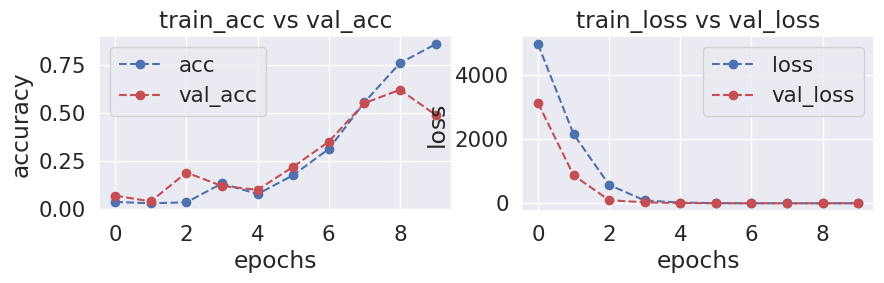

In [22]:
plot_accuracy_loss(history)

In [23]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    # tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    # tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(128, activation = tf.nn.softmax),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax')
])

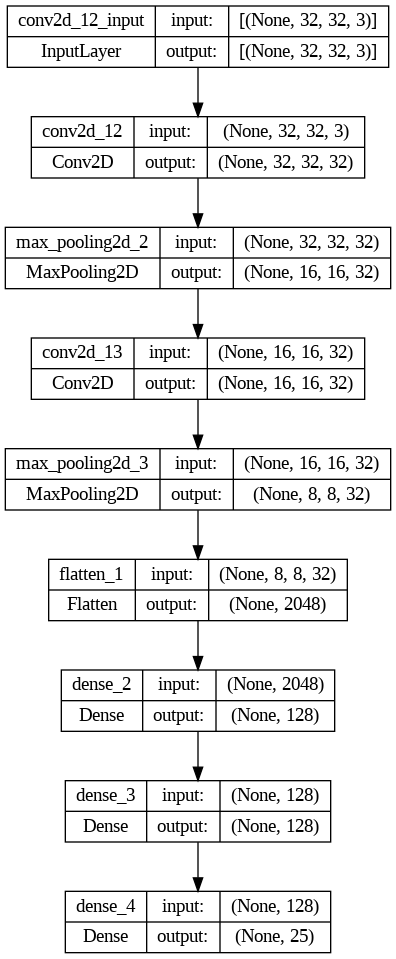

In [24]:
plot_model(model1, show_shapes=True, to_file='inception_module.png')

In [25]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               2

In [26]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [28]:
history = model1.fit(train_images, train_labels, batch_size=128, epochs=190, validation_split=0.2)

Epoch 1/190
4/4 [==============================] - 1s 137ms/step - loss: 3.2113 - accuracy: 0.1537 - val_loss: 3.2015 - val_accuracy: 0.1700
Epoch 2/190
4/4 [==============================] - 0s 123ms/step - loss: 3.2098 - accuracy: 0.1537 - val_loss: 3.2002 - val_accuracy: 0.1700
Epoch 3/190
4/4 [==============================] - 0s 114ms/step - loss: 3.2083 - accuracy: 0.1537 - val_loss: 3.1989 - val_accuracy: 0.1700
Epoch 4/190
4/4 [==============================] - 1s 128ms/step - loss: 3.2069 - accuracy: 0.1537 - val_loss: 3.1978 - val_accuracy: 0.1700
Epoch 5/190
4/4 [==============================] - 0s 117ms/step - loss: 3.2055 - accuracy: 0.1537 - val_loss: 3.1967 - val_accuracy: 0.1700
Epoch 6/190
4/4 [==============================] - 0s 115ms/step - loss: 3.2040 - accuracy: 0.1537 - val_loss: 3.1956 - val_accuracy: 0.1700
Epoch 7/190
4/4 [==============================] - 0s 111ms/step - loss: 3.2025 - accuracy: 0.1537 - val_loss: 3.1944 - val_accuracy: 0.1700
Epoch 8/190
4

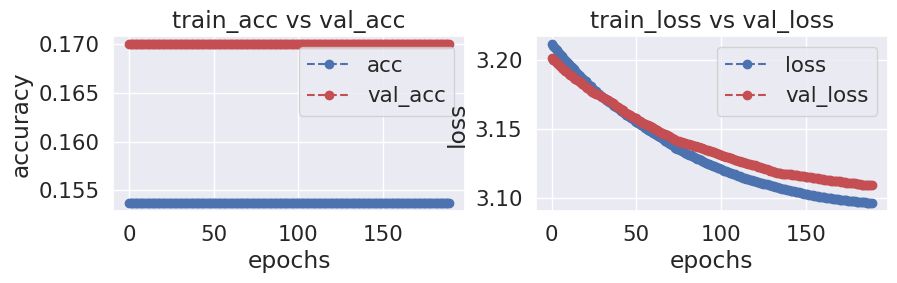

In [29]:
plot_accuracy_loss(history)

In [30]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same'),

    tf.keras.layers.Conv2D(128, (1, 1), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(192, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu', padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(train_dataset.num_classes, activation='softmax')
])

In [31]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
4/4 [==============================] - 35s 8s/step - loss: 3.1855 - accuracy: 0.1259 - val_loss: 3.2160 - val_accuracy: 0.0500
Epoch 2/10
4/4 [==============================] - 34s 8s/step - loss: 3.1113 - accuracy: 0.1234 - val_loss: 5.1561 - val_accuracy: 0.1700
Epoch 3/10
4/4 [==============================] - 33s 7s/step - loss: 3.9820 - accuracy: 0.1108 - val_loss: 3.2101 - val_accuracy: 0.0200
Epoch 4/10
4/4 [==============================] - 35s 8s/step - loss: 3.2865 - accuracy: 0.0705 - val_loss: 3.2185 - val_accuracy: 0.0100
Epoch 5/10
4/4 [==============================] - 32s 8s/step - loss: 3.2176 - accuracy: 0.0453 - val_loss: 3.2121 - val_accuracy: 0.0400
Epoch 6/10
4/4 [==============================] - 33s 8s/step - loss: 3.2171 - accuracy: 0.0982 - val_loss: 3.2173 - val_accuracy: 0.0600
Epoch 7/10
4/4 [==============================] - 32s 7s/step - loss: 3.2159 - accuracy: 0.0932 - val_loss: 3.2174 - val_accuracy: 0.1000
Epoch 8/10
4/4 [==================

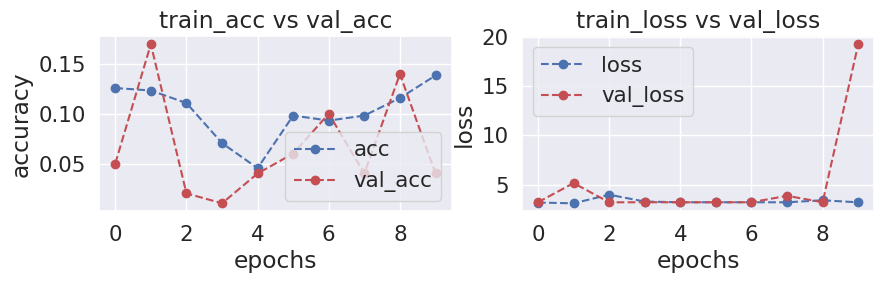

In [34]:
plot_accuracy_loss(history2)

In [35]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 64)        256       
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 128)       8320      
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 192)       221376    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 192)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        6176      
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       4224      
                                                      